In [1]:
# Justin Madsen
# DSC 540 / Catherine Williams

# import the boys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import ssl

import urllib.request, urllib.parse, urllib.error

import json

import os

import requests

import regex as re

import sqlite3

In [2]:
# import the csv. this has sales from 2006-2010
house_sales = pd.read_csv('house_sales.csv')

In [3]:
# .head to test
house_sales.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [4]:
# Unfortunately, because the data is already "cleaned" due it being a competition from Kaggle, the transformation
# pieces aren't really necessary here. Due to the sheer size, I'll be dropping some columns that I don't think will
# be all too necessary for the purposes of this project. tl;dr - I don't know what alot of these variables are,
# so I'll be cutting them out

In [5]:
# Let's drop all the columns that aren't necessary
house_sales_df = house_sales.drop(['GarageCond', 'WoodDeckSF', 'OpenPorchSF', 
                                      'EnclosedPorch', 'MiscFeature', 'LotConfig', 
                                      'BldgType', 'MiscVal', 'GarageYrBlt', 'GarageQual',
                                     '3SsnPorch', 'ScreenPorch', 'Fence', 'MoSold', 'SaleCondition',
                                     'PoolQC', 'Neighborhood', 'Utilities', 'LotShape', 'LandContour',
                                     'MSSubClass', 'MSZoning', 'Street', 'Alley', 'PoolArea',
                                     'LandSlope', 'Condition1', 'Condition2', 'FireplaceQu', 'GarageFinish',
                                     'RoofStyle', 'Functional', 'SaleType', 'Exterior1st', 'Exterior2nd', 
                                      'KitchenQual', 'HeatingQC', 'LowQualFinSF', 'MasVnrType', 'MasVnrArea', 
                                      'ExterCond', 'BsmtExposure','BsmtCond', 'GarageType', 'BsmtFinType1',
                                      'BsmtFinType2', 'BsmtFinSF1', 'BsmtFinSF2', 'Heating', 'LotFrontage',
                                      'BsmtQual', 'BsmtUnfSF', 'Electrical', 'BsmtHalfBath', 'BsmtFullBath',
                                      'ExterQual', 'Foundation', 'RoofMatl', 'Id', 'LotArea', 'HouseStyle', 
                                      'OverallQual', 'OverallCond','YearBuilt', 'YearRemodAdd', 'TotalBsmtSF',
                                      'CentralAir', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'HalfBath', 
                                      'BedroomAbvGr','KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
                                      'GarageArea', 'PavedDrive'] , axis = 1)

In [6]:
# test to see if it worked
house_sales_df.head(2)

,YrSold,SalePrice
0,2008,208500
1,2007,181500


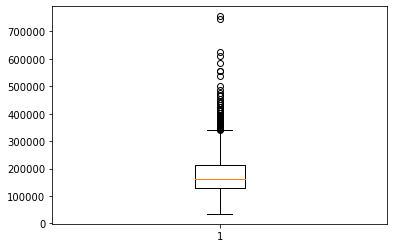

In [7]:
# let's look for price outliers
plt.boxplot(house_sales_df.SalePrice)
plt.show()

In [8]:
house_sales_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [9]:
# https://www.scribbr.com/statistics/outliers/
# let's determine the IQR (214000 - 129975)
q1 = 129975
q3 = 214000
iqr = q3 - q1

In [10]:
# Q3 + (1.5 * IQR)
upper_fence = q3 + (1.5 * iqr)
upper_fence

340037.5

In [11]:
# Q1 – (1.5 * IQR)
lower_fence = q1 - (1.5 * iqr)
lower_fence

3937.5

In [12]:
outliers = [element for element in house_sales_df['SalePrice'] if element > upper_fence]
number_of_outliers = len(outliers)
number_of_outliers

# this tells me that there are 61 outliers. However, this could be due to being closer to the end of the dataset
# where prices would naturally be higher. I don't intend on removing this outliers, as I would like to compare them
# to the data pulled from the Zillow API later to see how prices have moved overall.

61

In [13]:
# assign an object to hold the webpage. using open,'r' will let us read the page and store it into the object
webpage = open("Economy of the United States - Wikipedia.html", "r")

# assign a variable to a BeautifulSoup of the webpage
soup = BeautifulSoup(webpage)

# close the webpage, since we no longer need it open after the soup has been made
webpage.close()

In [14]:
# here we create an object to hold all tables with the class "wikitable"
data_table = soup.find("table", {"class": "wikitable"})
print(type(data_table))

<class 'bs4.element.Tag'>


In [15]:
# pull the wiki_df, this will turn it into a list
wiki_df=pd.read_html(str(data_table))

In [16]:
# make it a nice looking df
wiki_df = pd.DataFrame(wiki_df[0])
wiki_df.head(2)

,Year,GDP (in Bil. US$PPP),GDP per capita (in US$ PPP),GDP (in Bil. US$nominal),GDP per capita (in US$ nominal),GDP growth (real),Inflation rate (in Percent),Unemployment (in Percent),Government debt (in % of GDP)
0,1980,2857.3,12552.9,2857.3,12552.9,-0.3%,13.5%,7.2%,NaN
1,1981,3207.0,13948.7,3207.0,13948.7,2.5%,10.4%,7.6%,NaN


In [17]:
# I only pulled this data set for the inflation rate, so I'm going to drop several columns for
# the steps of transformations
wiki_df = wiki_df.drop('GDP (in Bil. US$PPP)', axis = 1)

In [18]:
# this is good information, however as stated above I'm looking for inflation rate to compare house price growth
wiki_df = wiki_df.drop('GDP per capita (in US$ PPP)', axis = 1)

In [19]:
wiki_df = wiki_df.drop('GDP (in Bil. US$nominal)', axis = 1)

In [20]:
wiki_df = wiki_df.drop('GDP per capita (in US$ nominal)', axis = 1)

In [21]:
wiki_df = wiki_df.drop('GDP growth (real)', axis = 1)

In [22]:
# this column would make an interesting comparison. How does unemployment rate affect home sales?
wiki_df = wiki_df.drop('Unemployment (in Percent)', axis = 1)

In [23]:
# for some reason, I was unable to drop the gov debt directly
wiki_df.columns

Index(['Year', 'Inflation rate (in Percent)', 'Government debt (in % of GDP)'], dtype='object')

In [24]:
# in lieu of using .drop, I just assigned the 2 columns I cared about into the df and called it good.
wiki_df = wiki_df[['Year', 'Inflation rate (in Percent)']]

In [77]:
# rename the column for easier reference
wiki_df.columns = ['Year', 'Inflation']

In [78]:
# interesting enough, I am able to see the forecasted growth of the economy through 2027. Meanwhile, I know that
# zillow is calling for a massive increase in housing prices over the next 2 years. 
wiki_df

,Year,Inflation
0,1980,13.5%
1,1981,10.4%
2,1982,6.2%
3,1983,3.2%
4,1984,4.4%
5,1985,3.5%
6,1986,1.9%
7,1987,3.6%
8,1988,4.1%
9,1989,4.8%


In [26]:
# open the consumer key file, then load the json into an object
with open('zillow.json') as f:
    key = json.load(f)
    api_key = key['apikey']

In [27]:
# set base url for api
base_url = 'https://apis.estated.com/v4/property'

In [28]:
# provide an address to pull
address = '360 Platteview Dr'
city = 'Springfield'
state = 'NE'
zip_code = '68059'

In [29]:
# set parameters
params = (('token', api_key), ('street_address', address),
         ('city', city), ('state', state), ('zip_code', zip_code))

In [30]:
# get the json response and make it legible
response = requests.get(base_url, params=params)
response_json = response.json()

In [31]:
# normalize the data, this isn't very readable in it's current state
estate_df = pd.json_normalize(data=response_json['data'])
estate_df.head(2)

,valuation,taxes,assessments,market_assessments,deeds,metadata.publishing_date,address.street_number,address.street_pre_direction,address.street_name,address.street_suffix,...,owner.name,owner.second_name,owner.unit_type,owner.unit_number,owner.formatted_street_address,owner.city,owner.state,owner.zip_code,owner.zip_plus_four_code,owner.owner_occupied
0,None,"[{'year': 2021, 'amount': 4827, 'exemptions': ...","[{'year': 2021, 'land_value': 24000, 'improvem...","[{'year': 2021, 'land_value': 24000, 'improvem...","[{'document_type': 'WARRANTY DEED', 'recording...",2021-09-01,360,None,PLATTEVIEW,DR,...,"MADSEN, JUSTIN",None,None,None,360 PLATTEVIEW DR,SPRINGFIELD,NE,68059,4758,YES


In [32]:
print('Keys available: {}', response_json['data'].keys())

Keys available: {} dict_keys(['metadata', 'address', 'parcel', 'structure', 'valuation', 'taxes', 'assessments', 'market_assessments', 'owner', 'deeds'])


In [33]:
# make a dictionary of the data
deeds_dict = response_json['data']['deeds']
df_deeds = pd.DataFrame(deeds_dict)
df_deeds

,document_type,recording_date,original_contract_date,deed_book,deed_page,document_id,sale_price,sale_price_description,transfer_tax,distressed_sale,...,buyer_state,buyer_zip_code,buyer_zip_plus_four_code,lender_name,lender_type,loan_amount,loan_type,loan_due_date,loan_finance_type,loan_interest_rate
0,WARRANTY DEED,2020-06-02,2020-05-28,None,None,2020-14897,230000,SALES PRICE COMPUTED FROM COUNTY TRANSFER TAX ...,517.5,False,...,None,None,None,MORTGAGE RESEARCH CENTER LLC,MORTGAGE COMPANY,234315,VETERAN AFFAIRS,2050-07-01,None,None


In [34]:
# drop all the columns I don't need. I just care about year sale and sale price
df_deeds = df_deeds.drop(['document_type', 'recording_date', 'original_contract_date',
       'deed_book', 'deed_page', 'document_id',
       'sale_price_description', 'transfer_tax', 'distressed_sale',
       'real_estate_owned', 'seller_first_name', 'seller_last_name',
       'seller2_first_name', 'seller2_last_name','lender_name', 'lender_type', 'loan_amount', 'loan_type',
       'loan_due_date', 'loan_finance_type', 'loan_interest_rate', 'seller_address', 'seller_unit_number', 
                          'seller_city', 'seller_state',
       'seller_zip_code', 'seller_zip_plus_four_code', 'buyer_first_name',
       'buyer_last_name', 'buyer2_first_name', 'buyer2_last_name', 'buyer_unit_type',
       'buyer_unit_number', 'buyer_city', 'buyer_state', 'buyer_zip_code',
       'buyer_zip_plus_four_code', 'buyer_address'], axis=1)

In [35]:
# add the year of the sale
df_deeds['year'] = 2020

In [36]:
# reorg the columns
api_df = df_deeds[['year', 'sale_price']]

In [37]:
# test to see if it worked
api_df

,year,sale_price
0,2020,230000


In [73]:
api_df.columns = ['YrSold', 'SalePrice']

In [66]:
# set an object to hold the connection to the sql database
conn = sqlite3.connect("house_sales_db")
cursor = conn.cursor()

In [67]:
# let's create our empty table
cursor.execute('CREATE TABLE IF NOT EXISTS house_sales_df (YrSold number, SalePrice number)')
conn.commit()

In [68]:
# let's push the df to the db
house_sales_df.to_sql('house_sales_df', conn, if_exists='replace', index = False)

In [70]:
# let's check to see if it worked
cursor.execute('''  
SELECT * FROM house_sales_df
          ''')

for row in cursor.fetchall():
    print(row)

(2008, 208500)
(2007, 181500)
(2008, 223500)
(2006, 140000)
(2008, 250000)
(2009, 143000)
(2007, 307000)
(2009, 200000)
(2008, 129900)
(2008, 118000)
(2008, 129500)
(2006, 345000)
(2008, 144000)
(2007, 279500)
(2008, 157000)
(2007, 132000)
(2010, 149000)
(2006, 90000)
(2008, 159000)
(2009, 139000)
(2006, 325300)
(2007, 139400)
(2008, 230000)
(2007, 129900)
(2010, 154000)
(2009, 256300)
(2010, 134800)
(2010, 306000)
(2006, 207500)
(2008, 68500)
(2008, 40000)
(2008, 149350)
(2008, 179900)
(2010, 165500)
(2007, 277500)
(2006, 309000)
(2009, 145000)
(2009, 153000)
(2010, 109000)
(2008, 82000)
(2006, 160000)
(2007, 170000)
(2007, 144000)
(2008, 130250)
(2006, 141000)
(2010, 319900)
(2009, 239686)
(2007, 249700)
(2009, 113000)
(2007, 127000)
(2007, 177000)
(2006, 114500)
(2010, 110000)
(2006, 385000)
(2007, 130000)
(2008, 180500)
(2009, 172500)
(2006, 196500)
(2006, 438780)
(2008, 124900)
(2006, 158000)
(2007, 101000)
(2007, 202500)
(2010, 140000)
(2009, 219500)
(2007, 317000)
(2010, 180000)

In [74]:
cursor.execute('CREATE TABLE IF NOT EXISTS house_sales_api (YrSold number, SalePrice number)')
conn.commit()

In [75]:
# let's push the df to the db
api_df.to_sql('house_sales_api', conn, if_exists='replace', index = False)

In [76]:
# let's check to see if it worked
cursor.execute('''  
SELECT * FROM house_sales_api
          ''')

for row in cursor.fetchall():
    print(row)

(2020, 230000)


In [79]:
cursor.execute('CREATE TABLE IF NOT EXISTS interest_rates (Year number, Inflation text)')
conn.commit()

In [80]:
# let's push the df to the db
wiki_df.to_sql('interest_rates', conn, if_exists='replace', index = False)

In [81]:
# let's check to see if it worked
cursor.execute('''  
SELECT * FROM interest_rates
          ''')

for row in cursor.fetchall():
    print(row)

(1980, '13.5%')
(1981, '10.4%')
(1982, '6.2%')
(1983, '3.2%')
(1984, '4.4%')
(1985, '3.5%')
(1986, '1.9%')
(1987, '3.6%')
(1988, '4.1%')
(1989, '4.8%')
(1990, '5.4%')
(1991, '4.2%')
(1992, '3.0%')
(1993, '3.0%')
(1994, '2.6%')
(1995, '2.8%')
(1996, '2.9%')
(1997, '2.3%')
(1998, '1.5%')
(1999, '2.2%')
(2000, '3.4%')
(2001, '2.8%')
(2002, '1.6%')
(2003, '2.3%')
(2004, '2.7%')
(2005, '3.4%')
(2006, '3.2%')
(2007, '2.9%')
(2008, '3.8%')
(2009, '-0.3%')
(2010, '1.6%')
(2011, '3.1%')
(2012, '2.1%')
(2013, '1.5%')
(2014, '1.6%')
(2015, '0.1%')
(2016, '1.3%')
(2017, '2.1%')
(2018, '2.4%')
(2019, '1.8%')
(2020, '1.2%')
(2021, '4.7%')
(2022, '7.7%')
(2023, '2.9%')
(2024, '2.3%')
(2025, '2.0%')
(2026, '2.0%')
(2027, '2.0%')


In [83]:
# let's see how many houses were sold in various years
for houses, year in cursor.execute("SELECT count(*), YrSold FROM house_sales_df GROUP BY YrSold"):
    print("{} houses were sold in {}".format(houses, year))

314 houses were sold in 2006
329 houses were sold in 2007
304 houses were sold in 2008
338 houses were sold in 2009
175 houses were sold in 2010


In [100]:
# this will count the number of houses that sold over 200K

# I also used 2 sets of quotations for multi-line strings to improve readability
price_200k = cursor.execute("SELECT count(*) FROM house_sales_df WHERE SalePrice >200000")
# print the number of people that were counted
for house in price_200k:
    print("{} houses have sold for more than 200K".format(house[0]))

427 houses have sold for more than 200K


In [102]:
# let's merge the api into the df
cursor.execute('''INSERT INTO house_sales_df
SELECT * FROM house_sales_api''')

In [103]:
# to test if this worked, let's rerun the previous visualizations. We should see an extra print line, and
# one increase to the number over 200K.
for houses, year in cursor.execute("SELECT count(*), YrSold FROM house_sales_df GROUP BY YrSold"):
    print("{} houses were sold in {}".format(houses, year))

314 houses were sold in 2006
329 houses were sold in 2007
304 houses were sold in 2008
338 houses were sold in 2009
175 houses were sold in 2010
1 houses were sold in 2020


In [104]:
# this will count the number of houses that sold over 200K

# I also used 2 sets of quotations for multi-line strings to improve readability
price_200k = cursor.execute("SELECT count(*) FROM house_sales_df WHERE SalePrice >200000")
# print the number of people that were counted
for house in price_200k:
    print("{} houses have sold for more than 200K".format(house[0]))

428 houses have sold for more than 200K


In [105]:
# Let's see how many houses sold for less than 120K
price_120k = cursor.execute("SELECT count(*) FROM house_sales_df WHERE SalePrice <120000")
# print the number of people that were counted
for house in price_120k:
    print("{} houses have sold for less than 120K".format(house[0]))

262 houses have sold for less than 120K


Summary

All things considered, I struggled the most with the API files. Between Zillow's functionality dropping off and Estated not letting me request multiple locations at a time, I chose to run with just the one address I used in a previous milestone. My biggest hangup was misunderstanding the assignment's end goal as well. I was anticipating having to model the data and prepare a presentation, whereas the real goal was to learn how to prepare the data and make it useable. 

Looking at it after the fact, I can already tell that only having 4 years of sales data is restrictive for what I was originally hoping to do anyway. Ethically, house sales are a matter of public record. However, many people see personal finance as a taboo topic and don't want to discuss their finances. Especially when looking at big dips/losses during the 08-09 market crashes.